In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tfds.disable_progress_bar()

In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset,info=tfds.load('imdb_reviews',with_info=True,as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX5J6G8/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX5J6G8/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteX5J6G8/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_dataset,test_dataset=dataset['train'],dataset['test']

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for text,label in train_dataset.take(1):
  print("text: ",text.numpy())
  print("label: ",label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I only watched this film from beginning to end because I promised a friend I would. It lacks even unintentional entertainment value that many bad films have. It may be the worst film I have ever seen. I'm surprised a distributor put their name on it."
 b"Only the glandular secretions -- and please don't ask for any more details -- of young virgins can keep the rapidly deteriorating body and mind of the crazed old amateur horticulturalist's wife fresh and youthful. Since, like most people except those taking part in medical trials, virgins seldom give up their secretions willingly, Dr. Lorenz (Bela Lugosi) arranges for them to be abducted and preserved. He'll do the extracting himself. <br /><br />What a great cheese ball of a premise for a low budget horror movie. If The Corpse Vanishes turns out not to be the Havarti of horror, as a plain limburger it leaves an interesting aftertaste. <br /><br />Sure, the acting is almost awful except for the actors fortunate enough to be 

In [11]:
VOCAB_SIZE=1000
encoder=tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text,label: text))

In [12]:
vocab=np.array(encoder.get_vocabulary())
vocab[0:25]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are'], dtype='<U14')

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  61, 284, ...,   0,   0,   0],
       [ 61,   2,   1, ...,   0,   0,   0],
       [  2,   1, 151, ...,   0,   0,   0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I only watched this film from beginning to end because I promised a friend I would. It lacks even unintentional entertainment value that many bad films have. It may be the worst film I have ever seen. I'm surprised a distributor put their name on it."
Round-trip:  i only watched this film from beginning to end because i [UNK] a friend i would it [UNK] even [UNK] entertainment [UNK] that many bad films have it may be the worst film i have ever seen im surprised a [UNK] put their name on it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [15]:
model=tf.keras.Sequential([encoder,
                          tf.keras.layers.Embedding(
                          input_dim=len(encoder.get_vocabulary()),
                          output_dim=64,mask_zero=True),
                          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                          tf.keras.layers.Dense(64, activation='relu'),
                          tf.keras.layers.Dense(1)])

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [17]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01359731]


In [18]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.0135973]


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 133s 320ms/step - loss: 0.6851 - accuracy: 0.5037 - val_loss: 0.4578 - val_accuracy: 0.7865
Epoch 2/10
391/391 [==============================] - 123s 313ms/step - loss: 0.4197 - accuracy: 0.8002 - val_loss: 0.3599 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 123s 313ms/step - loss: 0.3452 - accuracy: 0.8469 - val_loss: 0.3361 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 122s 311ms/step - loss: 0.3169 - accuracy: 0.8618 - val_loss: 0.3294 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 122s 312ms/step - loss: 0.3091 - accuracy: 0.8683 - val_loss: 0.3255 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 123s 313ms/step - loss: 0.3066 - accuracy: 0.8669 - val_loss: 0.3280 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 123s 312ms/step - loss: 0.3001 - accuracy: 0.8695 - val_loss: 0.3215 -

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

391/391 [==============================] - 48s 122ms/step - loss: 0.3239 - accuracy: 0.8639


In [22]:
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Test Loss: 0.3238796591758728
Test Accuracy: 0.8639199733734131


(0.0, 0.6665318176150322)

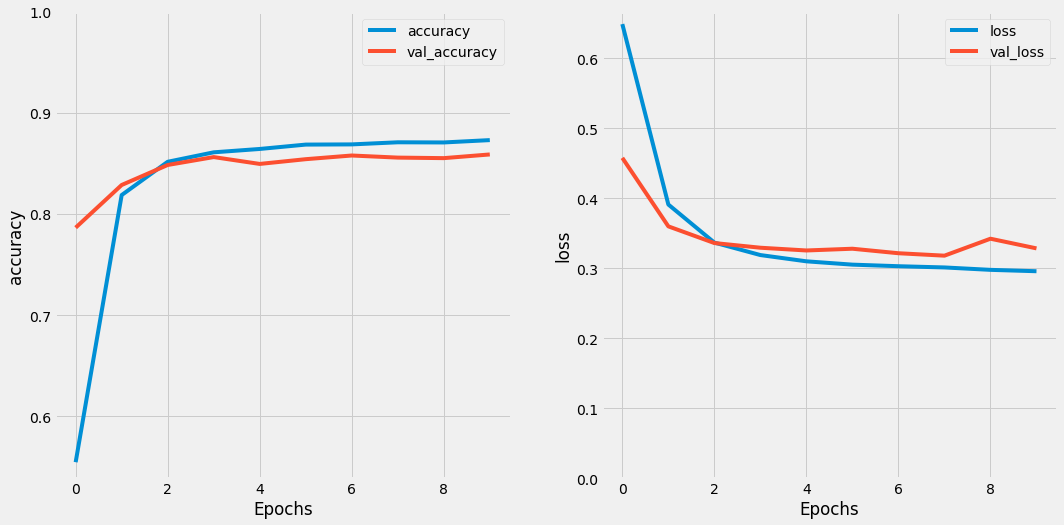

In [25]:
from matplotlib.pyplot import style
style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [29]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
prediction=model.predict(np.array([sample_text]))
if prediction[0][0]>0.0:
  print("Positive review")
else:
  print("Negative review")

Positive review


In [30]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 253s 596ms/step - loss: 0.6759 - accuracy: 0.5184 - val_loss: 0.4278 - val_accuracy: 0.8057
Epoch 2/10
391/391 [==============================] - 229s 585ms/step - loss: 0.4023 - accuracy: 0.8200 - val_loss: 0.3531 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 228s 582ms/step - loss: 0.3337 - accuracy: 0.8575 - val_loss: 0.3727 - val_accuracy: 0.8156
Epoch 4/10
391/391 [==============================] - 229s 583ms/step - loss: 0.3236 - accuracy: 0.8598 - val_loss: 0.3292 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 230s 586ms/step - loss: 0.3097 - accuracy: 0.8654 - val_loss: 0.3285 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 229s 584ms/step - loss: 0.3146 - accuracy: 0.8660 - val_loss: 0.3290 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 230s 586ms/step - loss: 0.3013 - accuracy: 0.8705 - val_loss: 0.3254 -

In [33]:

from tensorflow.keras.models import model_from_json

In [43]:
model.save('model')

NotImplementedError: ignored

In [40]:
loaded_model = tf.keras.models.load_model('model')

In [41]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
prediction=loaded_model.predict(np.array([sample_text]))
if prediction[0][0]>0.0:
  print("Positive review")
else:
  print("Negative review")

Negative review


In [46]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 90%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 69%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)


In [47]:
try:
  from google.colab import files
  files.download('/content/model.zip')
except Exception as e:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
test_loss, test_acc = loaded_model.evaluate(test_dataset)

391/391 [==============================] - 97s 231ms/step - loss: 0.3233 - accuracy: 0.8532


In [49]:
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Test Loss: 0.3233276307582855
Test Accuracy: 0.8532000184059143


(0.0, 0.6296293824911118)

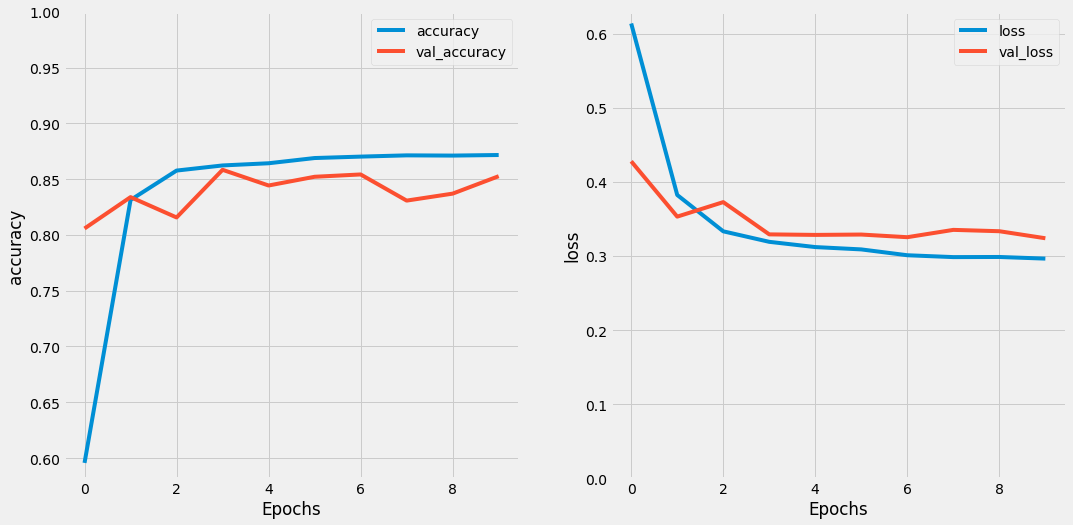

In [50]:
from matplotlib.pyplot import style
style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)